In [7]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Input, Model
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
from scipy.optimize import minimize_scalar
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
# mp.set_start_method("spawn") 
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-03-07 15:02:18.337293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 15:02:18.618917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



data_generation_parallel_generalized.py

```python
import numpy as np
from PIL import Image
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.models import load_model, Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

from time import time
from scipy.stats import poisson, gamma, norm
from scipy.optimize import minimize_scalar
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import logging
from datetime import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

logging.basicConfig(level=logging.INFO)


# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    model.compile(optimizer='adam', loss='mse')  # Compile the model
    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, random_state=random_state)
    intensity = gp.sample_y(coords, n_samples=1, random_state=random_state).reshape(grid_size, grid_size)
    
    intensity_scaled = scale_to_range(intensity)
    return intensity_scaled

# ---------------------------
# Simulation Functions
# ---------------------------

def generate_linear_effects(n_samples, I, K, alpha, random_state=None):
    """
    Generates linear effects for X1, X2, etc.
    alpha[k][i] is the coefficient for X_i in the k-th dimension of eta.
    """
    np.random.seed(random_state)
    # X has shape (I, n_samples)
    X = np.random.normal(size=(I, n_samples))
    X_scaled = np.zeros_like(X)
    linear_effects = np.zeros((I, n_samples, K))
    
    for i in range(I):
        X_scaled[i] = scale_to_range(X[i], 0, 1)
        for k in range(K):
            linear_effects[i, :, k] = alpha[k][i] * X_scaled[i]
        
    return X_scaled, scale_to_range(linear_effects)

def generate_nonlinear_effects(n_samples, J, K, beta, random_state=None):
    """
    Generates nonlinear effects for Z1, Z2, etc.
    beta[k][j] is a function, e.g. beta[0][0] = f(Z1).
    """
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(J, n_samples))  # shape (J, n_samples)
    nonlinear_effects = np.zeros((J, n_samples, K))

    for j in range(J):
        for k in range(K):
            nonlinear_effects[j, :, k] = beta[k][j](Z[j])
        
    return Z, scale_to_range(nonlinear_effects)

def generate_unstructured_effects(images, save_path, scenario_index, K):
    """
    Generates unstructured effects by passing images through a small DNN.
    """
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))
    
    # Build and train a small DNN (mock training here).
    grid_size = images.shape[1]  # e.g., 28 if images are 28x28
    dnn_model = build_dnn(grid_size * grid_size)
    
    # Mock training: We won't actually train, but let's do a quick .fit so the weights update a bit.
    # For demonstration, we just pass random data as 'y'.
    dnn_model.fit(images, np.random.rand(n_samples, 1), epochs=1, verbose=0)
    
    # Predict unstructured effects using the DNN model
    predictions = dnn_model.predict(images)
    
    # Extract the penultimate layer's output
    penultimate_layer_model = Model(inputs=dnn_model.inputs, outputs=dnn_model.layers[-2].output)
    penultimate_output = penultimate_layer_model.predict(images)

    # Extract the weights and bias from the final layer
    final_layer_weights, final_layer_bias = dnn_model.layers[-1].get_weights()

    # For simplicity, just scale predictions for each dimension k
    for k in range(K):
        unstructured_effects[:, k] = scale_to_range(predictions[:, 0])

    save_with_var_name(dnn_model, 'dnn_model', 'keras', save_path, scenario_index)
    return unstructured_effects, penultimate_output, final_layer_weights, final_layer_bias

def combine_effects(scenario_index, save_path,
                    unstructured_effects,
                    linear_effects,
                    nonlinear_effects,
                    distribution="poisson",
                    s=1,
                    add_linear=True,
                    add_nonlinear=False,
                    add_unstructured=False):
    """
    Combines the various effect components into etas and simulates responses.
    """
    scenario_index += f"_dist_{distribution}_SNR_{s}"
    K = linear_effects.shape[2]
    N = linear_effects.shape[1]  # Number of data points
    
    # Initialize etas: shape (N, K)
    etas = np.zeros((N, K))

    # For the first dimension (often 'location' or 'mean'):
    # Conditionally add linear
    if add_linear:
        etas[:, 0] += linear_effects[:, :, 0].sum(axis=0)
    # Conditionally add nonlinear
    if add_nonlinear:
        etas[:, 0] += nonlinear_effects[:, :, 0].sum(axis=0)
    # Conditionally add unstructured
    if add_unstructured:
        etas[:, 0] += unstructured_effects[:, 0]

    if distribution == "poisson":
        # Adjust for SNR
        a = find_a_for_target_snr(s, etas, "poisson")
        etas[:, 0] += a

    elif distribution == "gaussian_homo":
        # For homoscedastic Gaussian, we only have one dimension for mu in etas[:,0].
        # The second dimension is constant log-sigma => put it in etas[:,1].
        a = np.ptp(etas[:, 0])/s
        etas[:, 1] = a

    elif distribution == "gaussian_hetero":
        # For heteroscedastic Gaussian, we also have linear+nonlinear+unstructured for scale
        # in the second dimension (index 1).
        if add_linear:
            etas[:, 1] += linear_effects[:, :, 1].sum(axis=0)
        if add_nonlinear:
            etas[:, 1] += nonlinear_effects[:, :, 1].sum(axis=0)
        if add_unstructured:
            etas[:, 1] += unstructured_effects[:, 1]

        a = find_a_for_target_snr(s, etas, "gaussian_hetero")
        etas[:, 1] += a

    else:
        raise ValueError(f"Unsupported distribution: {distribution}")
    
    # Save offset a, etas, then simulate y
    save_with_var_name(a, 'a', 'npy', save_path, scenario_index)
    save_with_var_name(etas, 'etas', 'npy', save_path, scenario_index)
    y = simulate_response(etas, distribution, a)
    save_with_var_name(y, 'y', 'npy', save_path, scenario_index)

    return "done"

def combine_effects_wrapper(args):
    return combine_effects(*args)

def compute_snr(a, etas, dist):
    if dist == "poisson":
        lambda_vals = np.exp(etas[:, 0] + a)
        range_log_lambda = np.ptp(etas[:, 0] + a)
        mean_sqrt_lambda = np.sqrt(lambda_vals)
        return (range_log_lambda / mean_sqrt_lambda).mean()
    # if dist == "gaussian_homo":
    #     sigma = a
    #     range_mu = np.ptp(etas[:, 0])
    #     return (range_mu / sigma).mean()
    if dist == "gaussian_hetero":
        sigma = np.exp(etas[:, 1] + a)
        range_mu = np.ptp(etas[:, 0])
        return (range_mu / sigma).mean()

def find_a_for_target_snr(target_snr, etas, dist):
    def loss_function(a):
        computed_snr = compute_snr(a, etas, dist)
        return (computed_snr - target_snr)**2
    
    result = minimize_scalar(loss_function, bounds=(-10, 10), method='bounded')
    return result.x    

def simulate_response(etas, distribution, a):
    """
    Simulates final response y given etas and distribution.
    """
    n_samples = etas.shape[0]
    if "poisson" in distribution:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif "gamma" in distribution:
        mu = np.exp(etas[:, 0]) # non-negative
        sigma = a
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples) # scale must be non-negative
    elif "gaussian" in distribution:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])  # for hetero; if homo, etas[:,1] = const log-sigma
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

def save_with_var_name(var, var_name, var_type, save_path, scenario_index):
    """
    Helper to save various file types (npy, keras, jpgs).
    """
    if var_type == 'npy':
        np.save(f"{save_path}/{var_name}_{scenario_index}.npy", var)
    if var_type == 'keras':
        var.save(f"{save_path}/{var_name}_{scenario_index}.keras")
    if var_type == 'jpgs':
        images_path = f"{save_path}/{var_name}_{scenario_index}"
        os.makedirs(images_path, exist_ok=True)
        for idx, img in enumerate(var):
            normalized_img = (img * 255 / np.max(img)).astype(np.uint8)
            normalized_img = Image.fromarray(normalized_img).convert("L")
            normalized_img.save(f"{images_path}/{var_name}_{scenario_index}_{idx}.jpg")
    if var_type == 'npz':
        np.savez_compressed(f"{save_path}/{var_name}_{scenario_index}.npz", **var)
    logging.info(f"Saved {var_name} to {save_path}/{var_name}_{scenario_index}.npy")

def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    if var_type == 'keras':
        return tf.keras.models.load_model(f"{save_path}/{var_name}_{scenario_index}.keras")


# ---------------------------
# Main Task Generation
# ---------------------------

def generate_task(n_sample, distribution_list, SNR_list, grid_size, alpha_l, beta_nl, n_rep, 
                  save_path, compute_type='parallel',
                  add_linear=True,
                  add_nonlinear=False,
                  add_unstructured=False):
    """
    Generates one scenario (for a given n_sample and replication index),
    optionally including nonlinear and unstructured effects.
    """
    np.random.seed(n_sample + n_rep)
    logging.info(f"Generating dataset: Number of obs {n_sample} | Replication {n_rep}")

    I = 2
    K = 2  # location + scale dimension
    scenario_index = '_'.join(map(str, ['n', n_sample, 'rep', n_rep]))
    # 1) Generate linear effects
    if add_linear:
        X, linear_effects = generate_linear_effects(n_sample, I, K, alpha_l, random_state=n_sample+n_rep)
        save_with_var_name(X, 'X', 'npy', save_path, scenario_index)
        save_with_var_name(linear_effects, 'linear_effects', 'npy', save_path, scenario_index)
    else:
        # Create placeholders (zeros) so it contributes nothing to eta
        X = np.zeros((I, n_sample))
        linear_effects = np.zeros((I, n_sample, K))
    # 2) Generate nonlinear effects (only if add_nonlinear=True)
    if add_nonlinear:
        Z, nonlinear_effects = generate_nonlinear_effects(n_sample, I, K, beta_nl, random_state=n_sample+n_rep)
        save_with_var_name(Z, 'Z', 'npy', save_path, scenario_index)
        save_with_var_name(nonlinear_effects, 'nonlinear_effects', 'npy', save_path, scenario_index)
    else:
        # Create placeholders (zeros) so it contributes nothing to eta
        Z = np.zeros((I, n_sample))
        nonlinear_effects = np.zeros((I, n_sample, K))

    # 3) Generate images if unstructured is True
    if add_unstructured:
        images = np.zeros((n_sample, grid_size, grid_size))
        for i in range(n_sample):
            images[i] = generate_gp_image(grid_size, length_scale=0.2,
                                          random_state=(n_sample + n_rep)*n_sample - i)
        save_with_var_name(images, 'images', 'npy', save_path, scenario_index)
        save_with_var_name(images, 'images_jpg', 'jpgs', save_path, scenario_index)
    else:
        images = None

    logging.info(f"Generated X, Z, images: n={n_sample}, rep={n_rep}")

    # 5) Flatten images and generate unstructured effects if add_unstructured=True
    if add_unstructured:
        flattened_images = images.reshape(n_sample, -1)
        unstructured_effects, U_k, psi_k, b_k = generate_unstructured_effects(
            flattened_images, save_path, scenario_index, K
        )
        save_with_var_name(unstructured_effects, 'unstructured_effects', 'npy', save_path, scenario_index)
        save_with_var_name(U_k, 'U_k', 'npy', save_path, scenario_index)
        save_with_var_name(psi_k, 'psi_k', 'npy', save_path, scenario_index)
        save_with_var_name(b_k, 'b_k', 'npy', save_path, scenario_index)
    else:
        unstructured_effects = np.zeros((n_sample, K))

    # 6) Combine effects (for each distribution & SNR)
    if compute_type == 'parallel':
        # parallel computing can't be nested by default, so use ThreadPoolExecutor
        with ThreadPoolExecutor() as inner_executor:
            result = list(inner_executor.map(
                combine_effects_wrapper,
                [
                    (
                        scenario_index,
                        save_path,
                        unstructured_effects,
                        linear_effects,
                        nonlinear_effects,
                        d,
                        s,
                        add_linear,
                        add_nonlinear,
                        add_unstructured
                    )
                    for s in SNR_list for d in distribution_list
                ]
            ))
    else:  # compute_type == 'serial'
        for d in distribution_list:
            for s in SNR_list:
                combine_effects(
                    scenario_index,
                    save_path,
                    unstructured_effects,
                    linear_effects,
                    nonlinear_effects,
                    distribution=d,
                    s=s,
                    add_linear=add_linear,
                    add_nonlinear=add_nonlinear,
                    add_unstructured=add_unstructured
                )

    logging.info(f"Generated responses: Number of obs={n_sample}, Rep={n_rep}")

# ---------------------------
# Parallel Execution Function
# ---------------------------

def scenarios_generate(n_list,
                       distribution_list,
                       SNR_list,
                       grid_size,
                       alpha_l,
                       beta_nl,
                       n_rep,
                       n_cores,
                       compute_type='parallel',
                       add_linear=True,
                       add_nonlinear=False,
                       add_unstructured=False):
    """
    Main entry point to generate multiple scenarios in either parallel or serial.
    """
    logging.info(f"Starting {compute_type} dataset generation...")
    start_time = datetime.now()

    # Decide on the folder to store data
    if compute_type == 'parallel':
        save_path = os.path.join(os.environ["TMPDIR"], "output_modified")  # or another path
        # save_path = "../data_generation/output_structured[-1_1]"
    else:
        save_path = "../data_generation/output_structured[-1_1]"
    os.makedirs(save_path, exist_ok=True)

    # Prepare (n, rep) tasks
    n_r = [(i, r) for i in n_list for r in range(n_rep)]

    if compute_type == 'parallel':
        with mp.Pool(n_cores) as pool:
            pool.starmap(
                generate_task,
                [
                    (
                        i,
                        distribution_list,
                        SNR_list,
                        grid_size,
                        alpha_l,
                        beta_nl,
                        r,
                        save_path,
                        compute_type,
                        add_linear,
                        add_nonlinear,
                        add_unstructured
                    )
                    for (i, r) in n_r
                ]
            )
    else:  # compute_type == 'serial'
        for (i, r) in n_r:
            generate_task(
                n_sample=i,
                distribution_list=distribution_list,
                SNR_list=SNR_list,
                grid_size=grid_size,
                alpha_l=alpha_l,
                beta_nl=beta_nl,
                n_rep=r,
                save_path=save_path,
                compute_type=compute_type,
                add_linear=add_linear,
                add_nonlinear=add_nonlinear,
                add_unstructured=add_unstructured
            )

    end_time = datetime.now()
    logging.info(f"{compute_type.capitalize()} dataset generation completed in {end_time - start_time}.")

# ---------------------------
# Scenario Setup (Example)
# ---------------------------
if __name__ == "__main__":
    # Example usage:
    n_list = [100, 500, 1000]
    distribution_list = ["poisson", "gaussian_homo", "gaussian_hetero"]
    SNR_list = [1, 8]
    n_rep = 100  # for testing; can be 100 in real usage
    grid_size = 28
    n_core = mp.cpu_count()
    print(f"Number of cores: {n_core}")

    # Define linear coefficients alpha_l
    alpha_l = {
        0: [3, -1],      # For location: alpha_0 for X1, X2
        1: [-0.5, 6]     # For scale (or second dimension)
    }

    # Define some example nonlinear functions
    def nonlinear_effect_1_z1(z1):
        return scale_to_range(3 * np.sin(6 * z1))

    def nonlinear_effect_1_z2(z2):
        return scale_to_range(np.exp(5 * z2))

    def nonlinear_effect_2_z1(z1):
        return scale_to_range(np.cos(8 * z1))

    def nonlinear_effect_2_z2(z2):
        return scale_to_range(0.1 * np.sqrt(z2))

    # Put them into a dictionary: beta_nl[k][j]
    beta_nl = {
        0: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
        1: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
    }

    # Now call the main generator with add_nonlinear=False and add_unstructured=False
    scenarios_generate(
        n_list=n_list,
        distribution_list=distribution_list,
        SNR_list=SNR_list,
        grid_size=grid_size,
        alpha_l=alpha_l,
        beta_nl=beta_nl,
        n_rep=n_rep,
        n_cores=n_core,
        compute_type='parallel',   # or 'serial'
        add_linear=True,
        add_nonlinear=True,       # no nonlinear
        add_unstructured=True     # no unstructured
    )

```

X1 range: [0.00, 1.00]
X2 range: [0.00, 1.00]


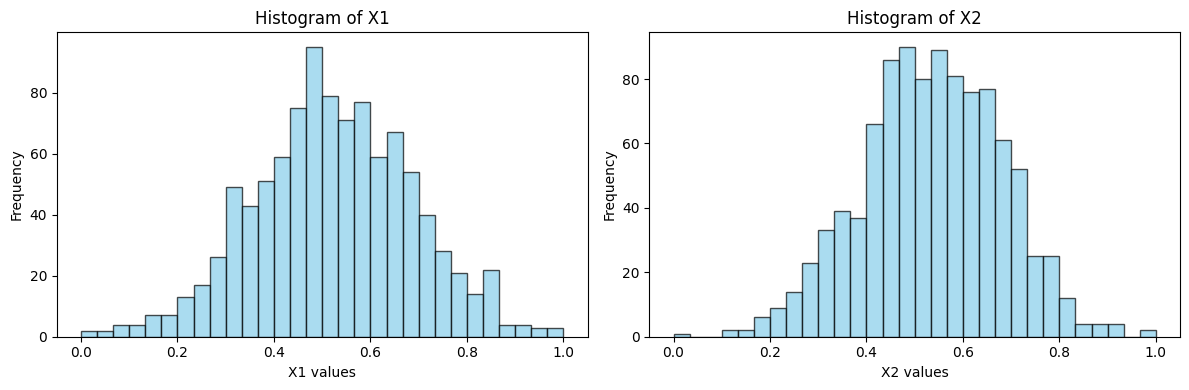

In [8]:
# ---------------------------
# Settings: adjust these as needed
# ---------------------------
n = 1000
rep = 0
dist = "gaussian_homo"
snr = 1
save_path = "./output_modified"  # Change this to your actual path

# Set the scenario index used in your simulation (e.g., "n_100_rep_0")
scenario_index_1 = f"n_{n}_rep_{rep}"
scenario_index_2 = f"{scenario_index_1}_dist_{dist}_SNR_{snr}"

# ---------------------------
# 1. Load Simulation Data
# ---------------------------
X = np.load(f"{save_path}/X_{scenario_index_1}.npy")  # Predictor values for linear effects
Z = np.load(f"{save_path}/Z_{scenario_index_1}.npy")  # Inputs for nonlinear effects
linear_effects = np.load(f"{save_path}/linear_effects_{scenario_index_1}.npy")
nonlinear_effects = np.load(f"{save_path}/nonlinear_effects_{scenario_index_1}.npy")

# ---------------------------
# 2. Visualize Histograms for X1 and X2
# ---------------------------
I, n_samples = X.shape  # I is the number of predictors, n_samples is the number of observations

plt.figure(figsize=(12, 4))
for i in range(I):
    plt.subplot(1, I, i + 1)
    plt.hist(X[i], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel(f"X{i+1} values")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of X{i+1}")
    
    # Print the range to the console
    x_min, x_max = np.min(X[i]), np.max(X[i])
    print(f"X{i+1} range: [{x_min:.2f}, {x_max:.2f}]")

plt.tight_layout()
plt.show()


For X1: X range: [0.00, 1.00]
Effect range: [-1.00, 1.00]
For X2: X range: [0.00, 1.00]
Effect range: [-1.00, 1.00]


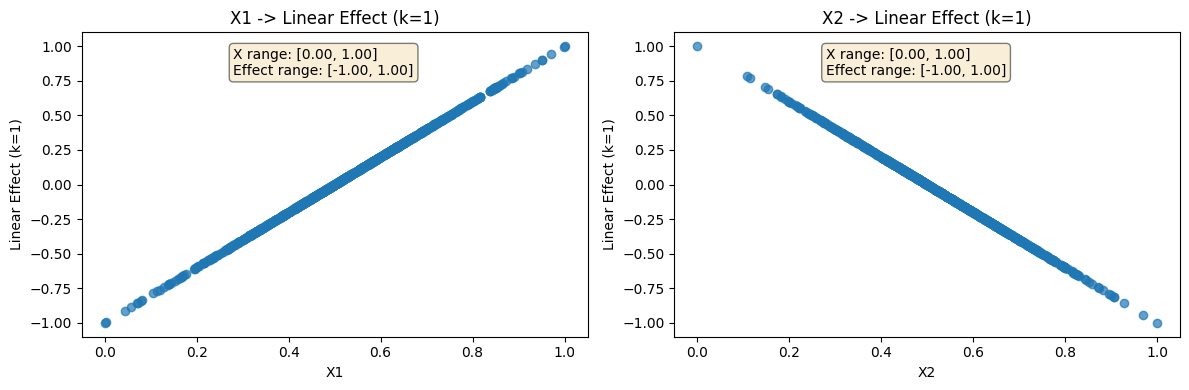

In [9]:
# ---------------------------
# 3. Visualize Linear Effects
# ---------------------------
# linear_effects shape: (I, n_samples, K) where I = number of predictors and K = number of dimensions (e.g., location & scale)
I, n_samples, K = linear_effects.shape

if dist == "gaussian_homo":
    plt.figure(figsize=(12, 4))
    k = 0  # Only using k=1 for the scale parameter defined by one intercept
    for i in range(I):
        ax = plt.subplot(1, I, i+1)
        ax.scatter(X[i], linear_effects[i, :, k], alpha=0.7)
        ax.set_xlabel(f"X{i+1}")
        ax.set_ylabel("Linear Effect (k=1)")
        ax.set_title(f"X{i+1} -> Linear Effect (k=1)")

        # Compute ranges for X and linear effects
        x_min, x_max = np.min(X[i]), np.max(X[i])
        effect_min, effect_max = np.min(linear_effects[i, :, k]), np.max(linear_effects[i, :, k])
        range_text = f"X range: [{x_min:.2f}, {x_max:.2f}]\nEffect range: [{effect_min:.2f}, {effect_max:.2f}]"
        
        # Print the range information to the console
        print(f"For X{i+1}: {range_text}")
        
        # Add text annotation to the plot (placed near the top-left of each subplot)
        ax.text(0.3, 0.95, range_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    plt.tight_layout()
    plt.show()

Z2 range: [0.00, 1.00]
Z2 range: [0.00, 1.00]


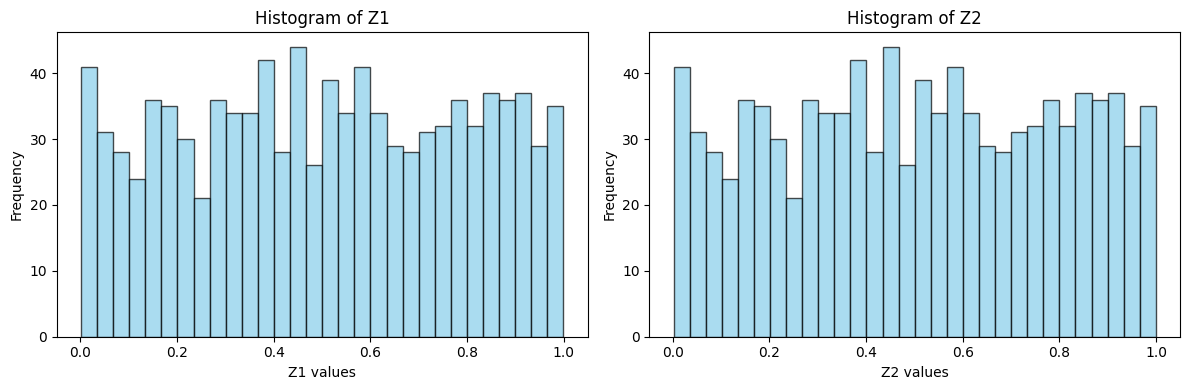

In [10]:
# ---------------------------
# 4. Visualize Histograms for X1 and X2
# ---------------------------
J, n_samples = Z.shape  # I is the number of predictors, n_samples is the number of observations

plt.figure(figsize=(12, 4))
for j in range(J):
    plt.subplot(1, J, j + 1)
    plt.hist(Z[i], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel(f"Z{j+1} values")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Z{j+1}")
    
    # Print the range to the console
    z_min, z_max = np.min(Z[i]), np.max(Z[i])
    print(f"Z{i+1} range: [{z_min:.2f}, {z_max:.2f}]")

plt.tight_layout()
plt.show()

For Z1: Z range: [0.00, 1.00]
Effect range: [-1.00, 1.00]
For Z2: Z range: [0.00, 1.00]
Effect range: [-1.00, 1.00]


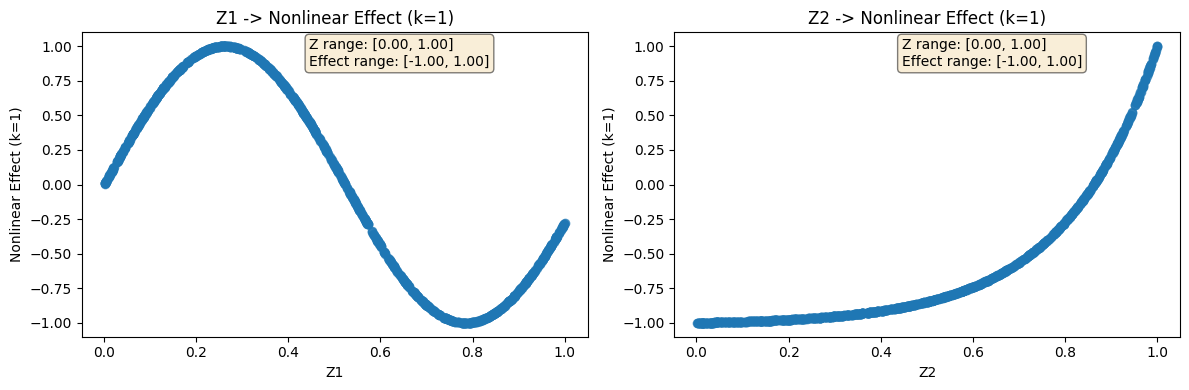

In [11]:
# ---------------------------
# 5. Visualize Nonlinear Effects
# ---------------------------
# nonlinear_effects shape: (J, n_samples, K) and Z shape: (J, n_samples), where J = number of nonlinear predictors
J = nonlinear_effects.shape[0]

if dist == "gaussian_homo":
    plt.figure(figsize=(12, 4))
    k = 0  # Only using k=1 for the scale parameter (one intercept)
    for j in range(J):
        ax = plt.subplot(1, J, j + 1)
        
        # Scatter plot of Z_j vs. nonlinear effect at dimension k
        ax.scatter(Z[j], nonlinear_effects[j, :, k], alpha=0.7)
        ax.set_xlabel(f"Z{j+1}")
        ax.set_ylabel("Nonlinear Effect (k=1)")
        ax.set_title(f"Z{j+1} -> Nonlinear Effect (k=1)")

        # Compute ranges for Z_j and the corresponding nonlinear effect
        z_min, z_max = np.min(Z[j]), np.max(Z[j])
        effect_min, effect_max = np.min(nonlinear_effects[j, :, k]), np.max(nonlinear_effects[j, :, k])
        range_text = (
            f"Z range: [{z_min:.2f}, {z_max:.2f}]\n"
            f"Effect range: [{effect_min:.2f}, {effect_max:.2f}]"
        )

        # Print the range information to the console
        print(f"For Z{j+1}: {range_text}")

        # Add text annotation to the plot (top-left corner)
        ax.text(
            0.45, 0.98,
            range_text,
            transform=ax.transAxes,
            fontsize=10,
            ha='left',
            va='top',
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
        )
    
    plt.tight_layout()
    plt.show()



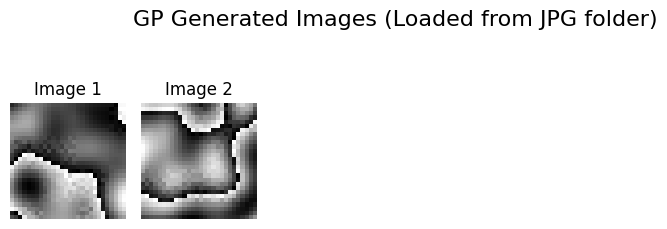

In [12]:
# ---------------------------
# 6. Visualize the GP-generated Images (from JPG folder)
# ---------------------------
# List and sort JPG files in the folder
folder_path = f"{save_path}/images_jpg_{scenario_index_1}"

image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
images_jpg = []

for file in image_files:
    file_path = os.path.join(folder_path, file)
    with Image.open(file_path) as img:
        # Convert to numpy array
        images_jpg.append(np.array(img))

images_jpg = np.array(images_jpg)

n_display = min(2, images_jpg.shape[0])
plt.figure(figsize=(8, 8))
for idx in range(n_display):
    plt.subplot(3, 6, idx + 1)
    plt.imshow(images_jpg[idx], cmap="gray")
    plt.title(f"Image {idx + 1}")
    plt.axis("off")
plt.suptitle("GP Generated Images (Loaded from JPG folder)", fontsize=16)
plt.tight_layout()
plt.show()

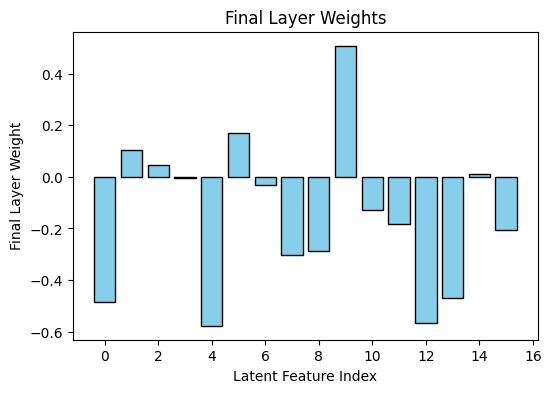

In [13]:
# ---------------------------
# 7. Visualize Final Layer Weights
# ---------------------------
psi_k = np.load(f"{save_path}/psi_k_{scenario_index_1}.npy")
plt.figure(figsize=(6, 4))
weights = psi_k.flatten()  # Flatten in case it's a column vector
plt.bar(range(len(weights)), weights, color='skyblue', edgecolor='black')
plt.xlabel("Latent Feature Index")
plt.ylabel("Final Layer Weight")
plt.title("Final Layer Weights")
plt.show()


Latent Feature 1 range: [0.00, 0.99]
Latent Feature 2 range: [0.00, 0.53]
Latent Feature 3 range: [0.00, 0.92]
Latent Feature 4 range: [0.00, 1.85]
Latent Feature 5 range: [0.00, 2.13]
Latent Feature 6 range: [0.00, 0.76]
Latent Feature 7 range: [0.00, 2.11]
Latent Feature 8 range: [0.00, 1.30]
Latent Feature 9 range: [0.00, 0.99]
Latent Feature 10 range: [0.00, 1.20]
Latent Feature 11 range: [0.00, 1.55]
Latent Feature 12 range: [0.00, 1.58]
Latent Feature 13 range: [0.00, 0.79]
Latent Feature 14 range: [0.00, 1.19]
Latent Feature 15 range: [0.00, 1.21]
Latent Feature 16 range: [0.00, 0.71]


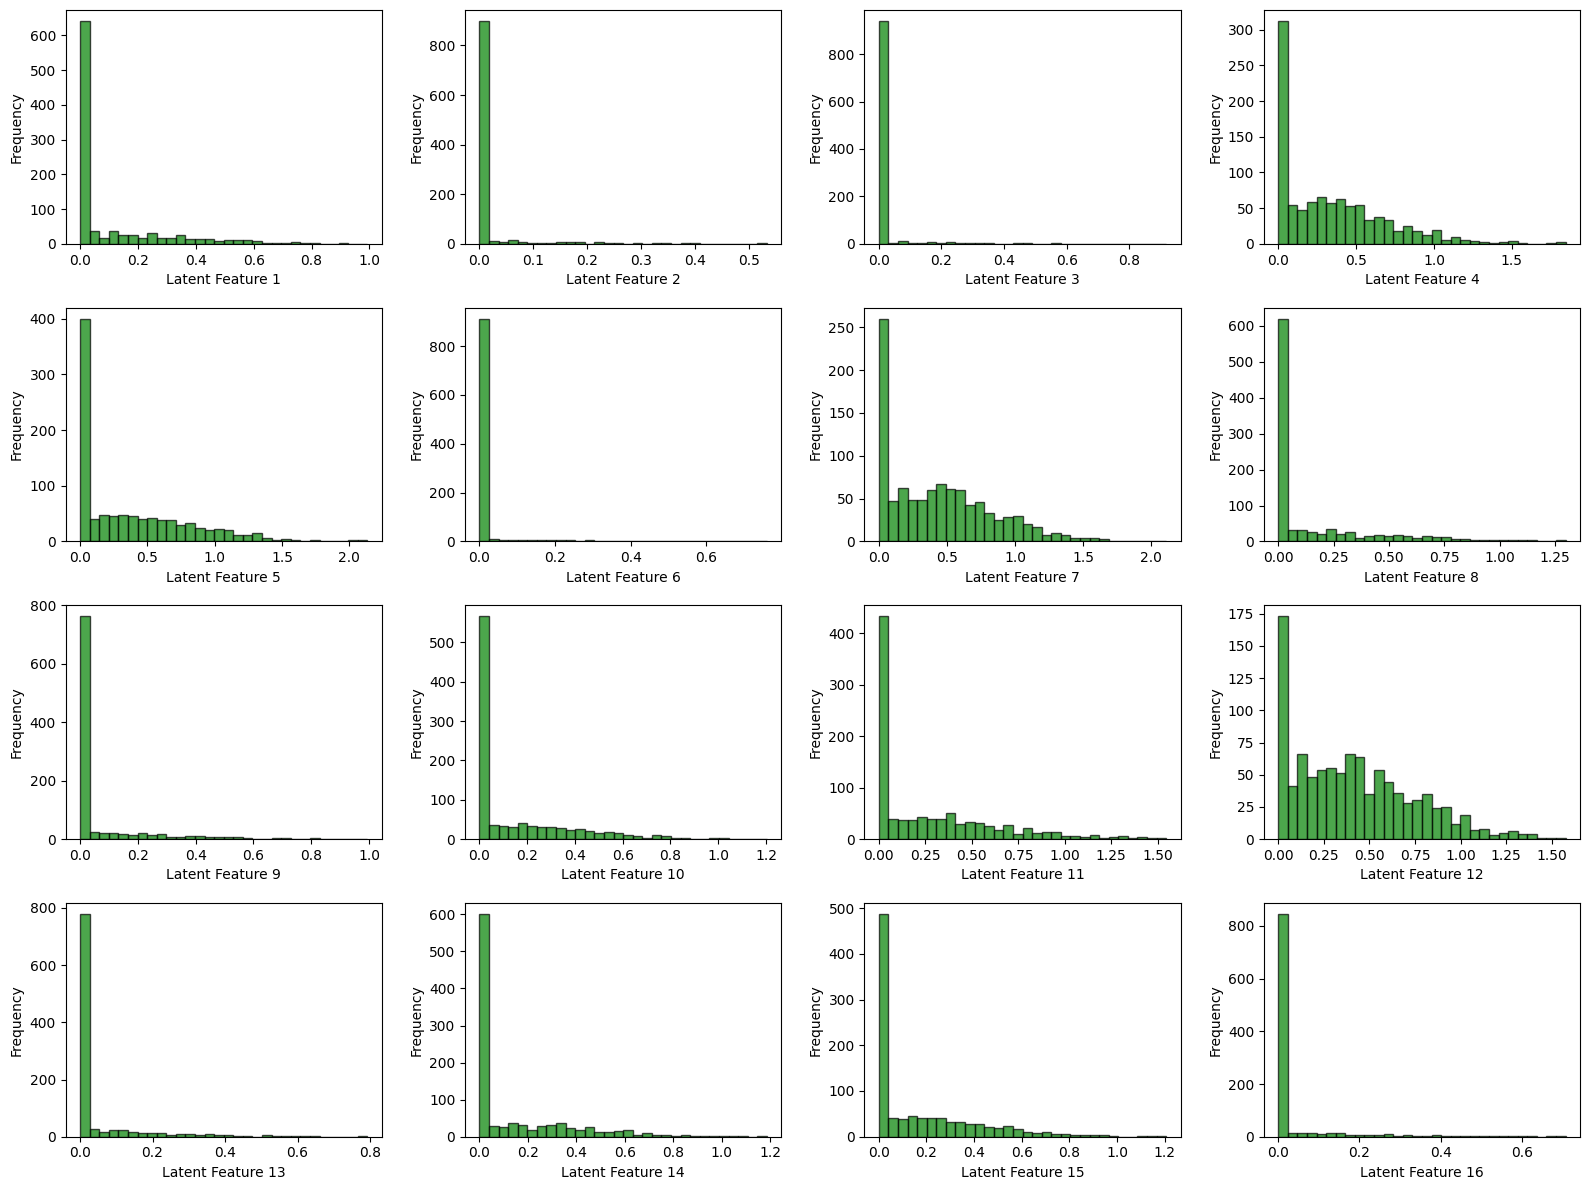

In [14]:
import math
U_k = np.load(f"{save_path}/U_k_{scenario_index_1}.npy")
# ---------------------------
# 8. Visualize Penultimate Output (Latent Features)
# ---------------------------
latent_dim = U_k.shape[1]

# Choose how many columns you want in the figure
n_cols = 4
# Compute the number of rows needed
n_rows = math.ceil(latent_dim / n_cols)

# Set up the figure size based on rows and columns
plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i in range(latent_dim):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.hist(U_k[:, i], bins=30, color='green', edgecolor='black', alpha=0.7)
    ax.set_xlabel(f"Latent Feature {i+1}")
    ax.set_ylabel("Frequency")

    # Print range information to the console
    pf_min, pf_max = np.min(U_k[:, i]), np.max(U_k[:, i])
    print(f"Latent Feature {i+1} range: [{pf_min:.2f}, {pf_max:.2f}]")

plt.tight_layout()
plt.show()


Unstructured Effect (k=1) range: [-1.00, 1.00]


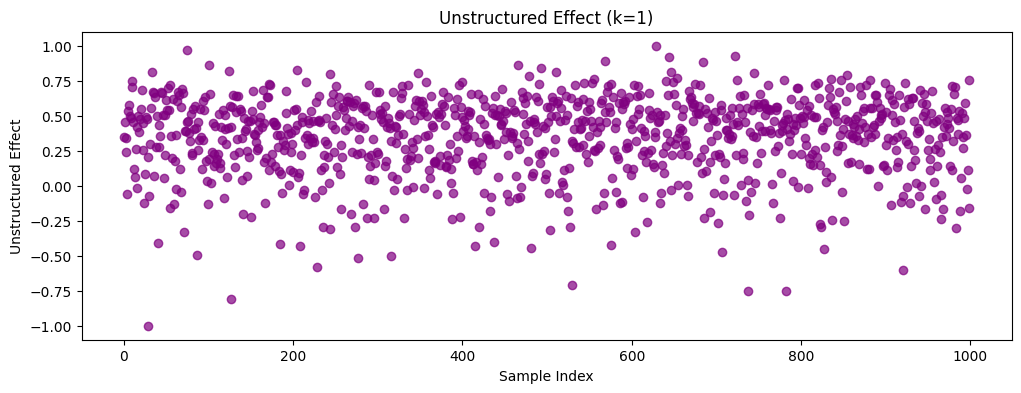

In [15]:
unstructured_effects = np.load(f"{save_path}/unstructured_effects_{scenario_index_1}.npy")
# ---------------------------
# 9. Visualize Unstructured Effects
# ---------------------------
K = unstructured_effects.shape[1]
plt.figure(figsize=(12, 4))
k = 0
# plt.subplot(1, K, k + 1)
plt.scatter(np.arange(unstructured_effects.shape[0]), unstructured_effects[:, k],
            alpha=0.7, color='purple')
plt.xlabel("Sample Index")
plt.ylabel("Unstructured Effect")
plt.title(f"Unstructured Effect (k={k+1})")
# Print range information to the console
ue_min, ue_max = np.min(unstructured_effects[:, k]), np.max(unstructured_effects[:, k])
print(f"Unstructured Effect (k={k+1}) range: [{ue_min:.2f}, {ue_max:.2f}]")
# plt.tight_layout()
plt.show()

In [16]:
# ---------------------------
# 10. Check the a is unique
# ---------------------------
a = np.load(f"{save_path}/a_{scenario_index_2}.npy")

print(a)

6.2525057134021615


In [17]:
# ---------------------------
# 11. Check the eta_1 is composed of linear, nonlinear and unstructured effects
# ---------------------------
etas = np.load(f"{save_path}/etas_{scenario_index_2}.npy")

lhs = etas[:, 0]
rhs = (linear_effects[:, :, 0].sum(axis=0)
        + nonlinear_effects[:, :, 0].sum(axis=0)
        + unstructured_effects[:, 0])

# Option 1: Strict element-wise equality (for exact matches)
assert np.array_equal(lhs, rhs), "Arrays are not exactly equal."

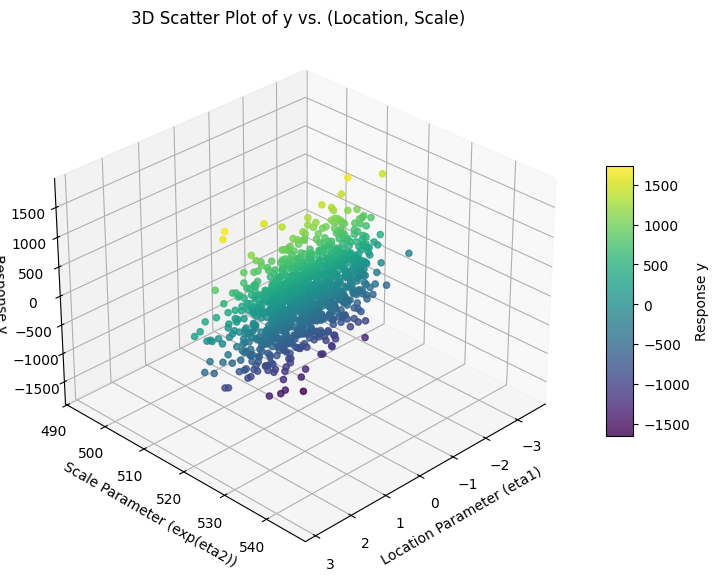

In [ ]:
# ---------------------------
# 12. Visualize y based on eta
# ---------------------------

y = np.load(f"{save_path}/y_{scenario_index_2}.npy")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# ---------------------------
# Load your data
# ---------------------------
# Assuming etas[:, 0] (location), etas[:, 1] (scale), and y (response)
location = etas[:, 0]
scale = np.exp(etas[:, 1])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(location, scale, y, c=y, cmap='viridis', alpha=0.8)

# Labels
ax.set_xlabel("Location Parameter (eta1)")
ax.set_ylabel("Scale Parameter (exp(eta2))")
ax.set_zlabel("Response y")
ax.set_title("3D Scatter Plot of y vs. (Location, Scale)")

# Colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Response y")

# Rotate manually
ax.view_init(elev=30, azim=45)

plt.show()


In [37]:
# ---------------------------
# 12. Check the SNR
# ---------------------------
def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    if var_type == 'keras':
        return tf.keras.models.load_model(f"{save_path}/{var_name}_{scenario_index}.keras")
def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower
def SNR_compute(n_list, distribution_list, SNR_list, save_path, n_rep=100):
    """
    Compute the SNR for scenarios to verify its correctness.

    Parameters:
    - n_list: List of sample sizes
    - distribution_list: List of distributions (e.g., ["poisson", "gamma", "gaussian"])
    - SNR_list: List of SNR values
    - grid_size: Size of the grid for unstructured effects
    - alpha_l: Coefficients for linear effects
    - beta_nl: Coefficients for nonlinear effects
    - n_rep: Number of repetitions for each scenario

    Returns:
    - Results of the SNR validation.
    """
    results = []

    for n in n_list:
        for rep in range(n_rep):
            scenario_index = f"n_{n}_rep_{rep}"
            # Read the effects and response data
            for dist in distribution_list:
                for snr in SNR_list:
                    dist_snr_index = f"{scenario_index}_dist_{dist}_SNR_{snr}"
                    a = read_with_var_name('a', 'npy', save_path, dist_snr_index)
                    etas = read_with_var_name('etas', 'npy', save_path, dist_snr_index)
                    # responses = read_with_var_name('responses', 'npy', save_path, dist_snr_index)
                    # print(dist_snr_index,":", etas)
                    ptp_eta = np.ptp(etas[:, 0])
                    if dist == "poisson":
                        snr_computed = (ptp_eta / np.sqrt(np.exp(etas[:, 0]))).mean()
                    # elif dist == "gamma":
                    #     snr_computed = ptp_eta / a # sigma
                    elif dist == "gaussian_homo":
                        std_eta = a
                        snr_computed = (ptp_eta / std_eta).mean()
                    elif dist == "gaussian_hetero":
                        std_eta = np.exp(etas[:, 1])
                        snr_computed = (ptp_eta / std_eta).mean()
                    else:
                        raise ValueError(f"Unsupported distribution: {dist}")
                    results.append({
                            "n": n,
                            "rep": rep,
                            "distribution": dist,
                            "SNR": snr,
                            "computed_SNR": snr_computed
                        })
    return results


In [ ]:
n_list = [1000]
distribution_list = ["poisson", "gaussian_homo", "gaussian_hetero"] #["poisson", "gamma", "gaussian"]
n_rep=2
SNR_list = [1, 8]
result = pd.DataFrame(SNR_compute(n_list, distribution_list, SNR_list, save_path, n_rep=n_rep))

In [39]:
result

,n,rep,distribution,SNR,computed_SNR
0,1000,0,poisson,1,1.000000
1,1000,0,poisson,8,8.000000
2,1000,0,gaussian_homo,1,1.000000
3,1000,0,gaussian_homo,8,8.000000
4,1000,0,gaussian_hetero,1,1.000000
5,1000,0,gaussian_hetero,8,7.999988
6,1000,1,poisson,1,1.000001
7,1000,1,poisson,8,7.999995
8,1000,1,gaussian_homo,1,1.000000
9,1000,1,gaussian_homo,8,8.000000


X1 range: [0.00, 1.00]
X2 range: [0.00, 1.00]


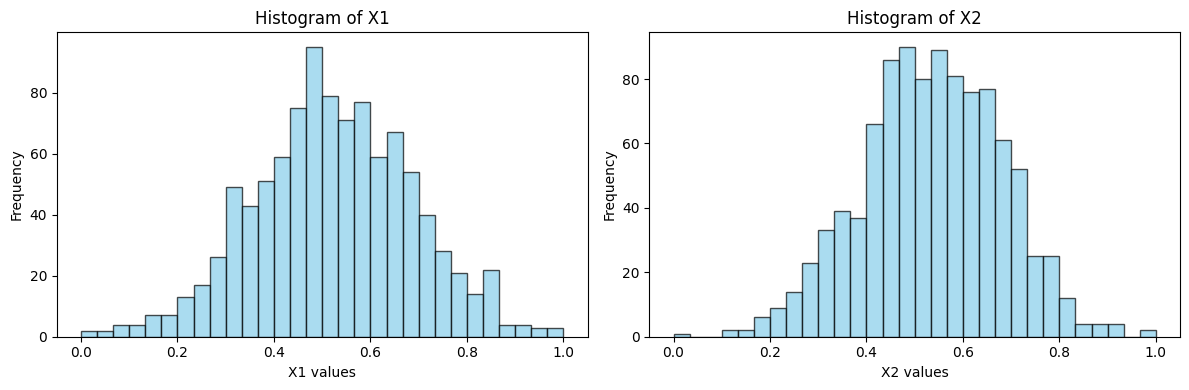

In [23]:
### without unstructured data
# ---------------------------
# Settings: adjust these as needed
# ---------------------------
n = 1000
rep = 0
dist = "gaussian_homo"
snr = 1
save_path = "./output_modified_wo_unstructured"  # Change this to your actual path

# Set the scenario index used in your simulation (e.g., "n_100_rep_0")
scenario_index_1 = f"n_{n}_rep_{rep}"
scenario_index_2 = f"{scenario_index_1}_dist_{dist}_SNR_{snr}"

# ---------------------------
# 1. Load Simulation Data
# ---------------------------
X = np.load(f"{save_path}/X_{scenario_index_1}.npy")  # Predictor values for linear effects
Z = np.load(f"{save_path}/Z_{scenario_index_1}.npy")  # Inputs for nonlinear effects
linear_effects = np.load(f"{save_path}/linear_effects_{scenario_index_1}.npy")
nonlinear_effects = np.load(f"{save_path}/nonlinear_effects_{scenario_index_1}.npy")

# ---------------------------
# 2. Visualize Histograms for X1 and X2
# ---------------------------
I, n_samples = X.shape  # I is the number of predictors, n_samples is the number of observations

plt.figure(figsize=(12, 4))
for i in range(I):
    plt.subplot(1, I, i + 1)
    plt.hist(X[i], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel(f"X{i+1} values")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of X{i+1}")
    
    # Print the range to the console
    x_min, x_max = np.min(X[i]), np.max(X[i])
    print(f"X{i+1} range: [{x_min:.2f}, {x_max:.2f}]")

plt.tight_layout()
plt.show()



For X1: X range: [0.00, 1.00]
Effect range: [-1.00, 1.00]
For X2: X range: [0.00, 1.00]
Effect range: [-1.00, 1.00]


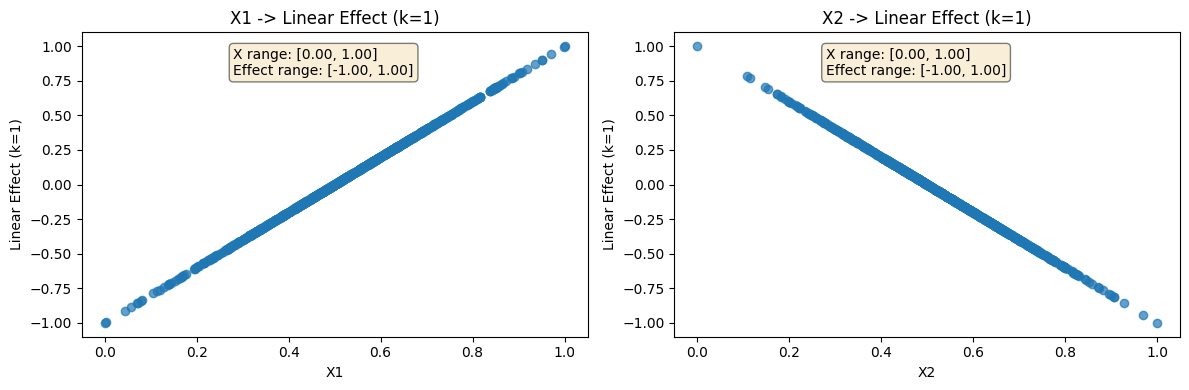

In [24]:
# ---------------------------
# 3. Visualize Linear Effects
# ---------------------------
# linear_effects shape: (I, n_samples, K) where I = number of predictors and K = number of dimensions (e.g., location & scale)
I, n_samples, K = linear_effects.shape

if dist == "gaussian_homo":
    plt.figure(figsize=(12, 4))
    k = 0  # Only using k=1 for the scale parameter defined by one intercept
    for i in range(I):
        ax = plt.subplot(1, I, i+1)
        ax.scatter(X[i], linear_effects[i, :, k], alpha=0.7)
        ax.set_xlabel(f"X{i+1}")
        ax.set_ylabel("Linear Effect (k=1)")
        ax.set_title(f"X{i+1} -> Linear Effect (k=1)")

        # Compute ranges for X and linear effects
        x_min, x_max = np.min(X[i]), np.max(X[i])
        effect_min, effect_max = np.min(linear_effects[i, :, k]), np.max(linear_effects[i, :, k])
        range_text = f"X range: [{x_min:.2f}, {x_max:.2f}]\nEffect range: [{effect_min:.2f}, {effect_max:.2f}]"
        
        # Print the range information to the console
        print(f"For X{i+1}: {range_text}")
        
        # Add text annotation to the plot (placed near the top-left of each subplot)
        ax.text(0.3, 0.95, range_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    plt.tight_layout()
    plt.show()

Z2 range: [0.00, 1.00]
Z2 range: [0.00, 1.00]


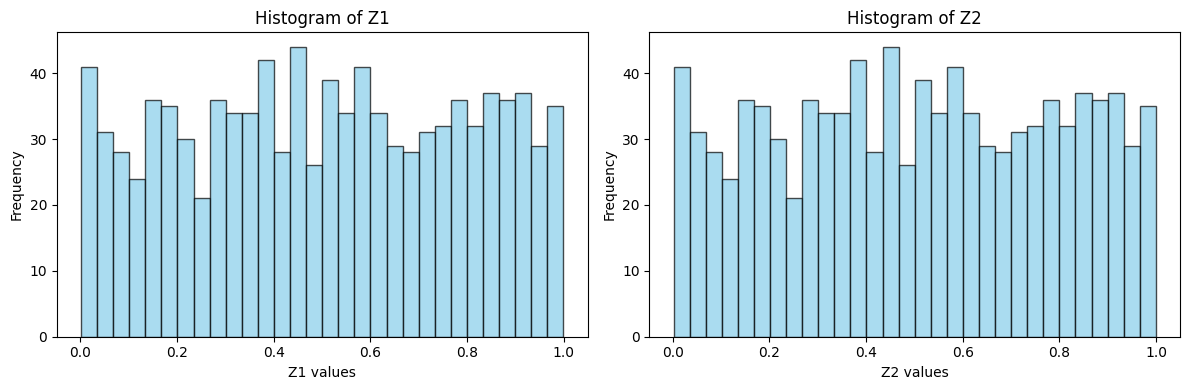

In [25]:
# ---------------------------
# 4. Visualize Histograms for X1 and X2
# ---------------------------
J, n_samples = Z.shape  # I is the number of predictors, n_samples is the number of observations

plt.figure(figsize=(12, 4))
for j in range(J):
    plt.subplot(1, J, j + 1)
    plt.hist(Z[i], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel(f"Z{j+1} values")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Z{j+1}")
    
    # Print the range to the console
    z_min, z_max = np.min(Z[i]), np.max(Z[i])
    print(f"Z{i+1} range: [{z_min:.2f}, {z_max:.2f}]")

plt.tight_layout()
plt.show()

For Z1: Z range: [0.00, 1.00]
Effect range: [-1.00, 1.00]
For Z2: Z range: [0.00, 1.00]
Effect range: [-1.00, 1.00]


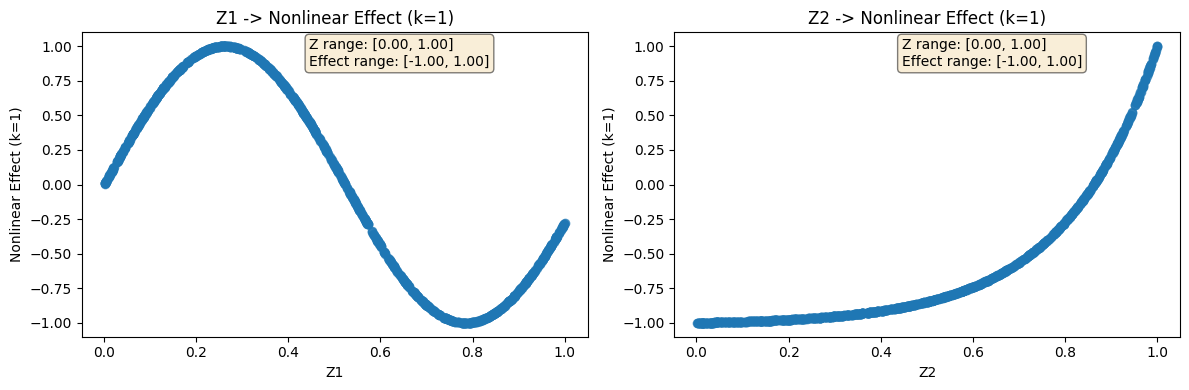

In [26]:
# ---------------------------
# 5. Visualize Nonlinear Effects
# ---------------------------
# nonlinear_effects shape: (J, n_samples, K) and Z shape: (J, n_samples), where J = number of nonlinear predictors
J = nonlinear_effects.shape[0]

if dist == "gaussian_homo":
    plt.figure(figsize=(12, 4))
    k = 0  # Only using k=1 for the scale parameter (one intercept)
    for j in range(J):
        ax = plt.subplot(1, J, j + 1)
        
        # Scatter plot of Z_j vs. nonlinear effect at dimension k
        ax.scatter(Z[j], nonlinear_effects[j, :, k], alpha=0.7)
        ax.set_xlabel(f"Z{j+1}")
        ax.set_ylabel("Nonlinear Effect (k=1)")
        ax.set_title(f"Z{j+1} -> Nonlinear Effect (k=1)")

        # Compute ranges for Z_j and the corresponding nonlinear effect
        z_min, z_max = np.min(Z[j]), np.max(Z[j])
        effect_min, effect_max = np.min(nonlinear_effects[j, :, k]), np.max(nonlinear_effects[j, :, k])
        range_text = (
            f"Z range: [{z_min:.2f}, {z_max:.2f}]\n"
            f"Effect range: [{effect_min:.2f}, {effect_max:.2f}]"
        )

        # Print the range information to the console
        print(f"For Z{j+1}: {range_text}")

        # Add text annotation to the plot (top-left corner)
        ax.text(
            0.45, 0.98,
            range_text,
            transform=ax.transAxes,
            fontsize=10,
            ha='left',
            va='top',
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
        )
    
    plt.tight_layout()
    plt.show()



In [27]:
# ---------------------------
# 10. Check the a is unique
# ---------------------------
a = np.load(f"{save_path}/a_{scenario_index_2}.npy")

print(a)

5.31154450007123


In [31]:
# ---------------------------
# 11. Check the eta_1 is composed of linear, nonlinear and unstructured effects
# ---------------------------
etas = np.load(f"{save_path}/etas_{scenario_index_2}.npy")

lhs = etas[:, 0]
rhs = (linear_effects[:, :, 0].sum(axis=0)
        + nonlinear_effects[:, :, 0].sum(axis=0))

# Option 1: Strict element-wise equality (for exact matches)
assert np.array_equal(lhs, rhs), "Arrays are not exactly equal."

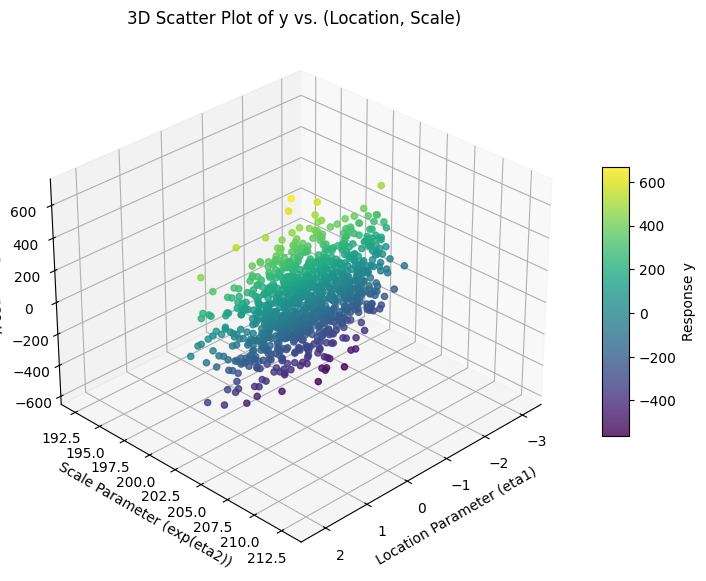

In [32]:
# ---------------------------
# 12. Visualize y based on eta
# ---------------------------

y = np.load(f"{save_path}/y_{scenario_index_2}.npy")

# ---------------------------
# Load your data
# ---------------------------
# Assuming etas[:, 0] (location), etas[:, 1] (scale), and y (response)
location = etas[:, 0]
scale = np.exp(etas[:, 1])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(location, scale, y, c=y, cmap='viridis', alpha=0.8)

# Labels
ax.set_xlabel("Location Parameter (eta1)")
ax.set_ylabel("Scale Parameter (exp(eta2))")
ax.set_zlabel("Response y")
ax.set_title("3D Scatter Plot of y vs. (Location, Scale)")

# Colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Response y")

# Rotate manually
ax.view_init(elev=30, azim=45)

plt.show()


In [35]:
# ---------------------------
# 12. Check the SNR
# ---------------------------
def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    if var_type == 'keras':
        return tf.keras.models.load_model(f"{save_path}/{var_name}_{scenario_index}.keras")
def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower
def SNR_compute(n_list, distribution_list, SNR_list, save_path, n_rep=100):
    """
    Compute the SNR for scenarios to verify its correctness.

    Parameters:
    - n_list: List of sample sizes
    - distribution_list: List of distributions (e.g., ["poisson", "gamma", "gaussian"])
    - SNR_list: List of SNR values
    - grid_size: Size of the grid for unstructured effects
    - alpha_l: Coefficients for linear effects
    - beta_nl: Coefficients for nonlinear effects
    - n_rep: Number of repetitions for each scenario

    Returns:
    - Results of the SNR validation.
    """
    results = []

    for n in n_list:
        for rep in range(n_rep):
            scenario_index = f"n_{n}_rep_{rep}"
            # Read the effects and response data
            for dist in distribution_list:
                for snr in SNR_list:
                    dist_snr_index = f"{scenario_index}_dist_{dist}_SNR_{snr}"
                    a = read_with_var_name('a', 'npy', save_path, dist_snr_index)
                    etas = read_with_var_name('etas', 'npy', save_path, dist_snr_index)
                    # responses = read_with_var_name('responses', 'npy', save_path, dist_snr_index)
                    # print(dist_snr_index,":", etas)
                    ptp_eta = np.ptp(etas[:, 0])
                    if dist == "poisson":
                        snr_computed = (ptp_eta / np.sqrt(np.exp(etas[:, 0]))).mean()
                    # elif dist == "gamma":
                    #     snr_computed = ptp_eta / a # sigma
                    elif dist == "gaussian_homo":
                        std_eta = a
                        snr_computed = (ptp_eta / std_eta).mean()
                    elif dist == "gaussian_hetero":
                        std_eta = np.exp(etas[:, 1])
                        snr_computed = (ptp_eta / std_eta).mean()
                    else:
                        raise ValueError(f"Unsupported distribution: {dist}")
                    results.append({
                            "n": n,
                            "rep": rep,
                            "distribution": dist,
                            "SNR": snr,
                            "computed_SNR": snr_computed
                        })
    return results


In [ ]:
n_list = [1000]
distribution_list = ["poisson", "gaussian_homo", "gaussian_hetero"] #["poisson", "gamma", "gaussian"]
n_rep=2
SNR_list = [1, 8]
result = pd.DataFrame(SNR_compute(n_list, distribution_list, SNR_list, save_path, n_rep=n_rep))

In [ ]:
result

,n,rep,distribution,SNR,computed_SNR
0,1000,0,poisson,1,1.000001
1,1000,0,poisson,8,8.000001
2,1000,0,gaussian_homo,1,1.000000
3,1000,0,gaussian_homo,8,8.000015
4,1000,0,gaussian_hetero,1,1.000000
5,1000,0,gaussian_hetero,8,8.000001
6,1000,1,poisson,1,1.000000
7,1000,1,poisson,8,8.000004
8,1000,1,gaussian_homo,1,1.000000
9,1000,1,gaussian_homo,8,8.000000
